Data Preprocessing and Enhancement
a) Data Loading and Basic Augmentation

Data Augmentation: Implement transformations such as rotations, flips, color adjustments, and cropping to increase data variability and improve model generalization.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image dimensions
img_height, img_width = 64, 64  # EuroSAT images are 64x64 pixels
#from google.colab.patches import cv2_imshow # Import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')
#test_data = datagen.flow_from_directory(
   # '/content/drive/MyDrive/Eurosat/2750/',
# Data directory
data_dir = '/content/drive/MyDrive/Eurosat2/2750/'

# Data Augmentation setup
datagen = ImageDataGenerator(
    rescale=1.0/255,       # Normalize pixel values
    rotation_range=20,     # Rotate images
    width_shift_range=0.2, # Shift images horizontally
    height_shift_range=0.2, # Shift images vertically
    horizontal_flip=True,   # Flip images horizontally
    vertical_flip=True,     # Flip images vertically
    validation_split=0.2    # Split data into training and validation sets
)

# Load training data
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Mounted at /content/drive
Found 1503 images belonging to 10 classes.
Found 371 images belonging to 10 classes.


b) Noise Reduction (Gaussian Blur)

•	Noise Reduction: Apply filters (Gaussian or median) to reduce image noise, enhancing image quality.

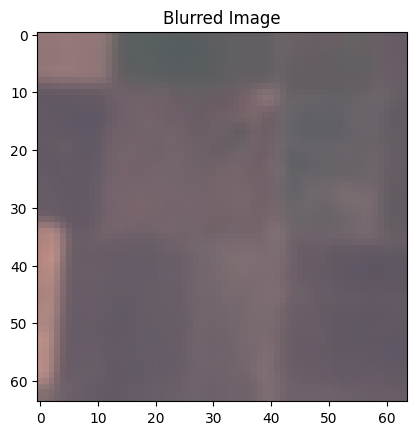

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

# Apply to a sample image
# Replace "path_to_image" with the actual path to your image
sample_image = cv2.imread("/content/drive/MyDrive/Eurosat2/2750/AnnualCrop/AnnualCrop_1.jpg")
# Check if image loading was successful
if sample_image is None:
    print("Error: Could not load image. Please check the file path.")
else:
    blurred_image = apply_gaussian_blur(sample_image)

    # Display the blurred image
    plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
    plt.title("Blurred Image")
    plt.show()

**2. Exploratory Data Analyses (EDA)**
a) Class Distribution Visualization

Class Imbalance Analysis: Identify any imbalances in the dataset’s 10 classes and propose solutions such as oversampling or class weighting.


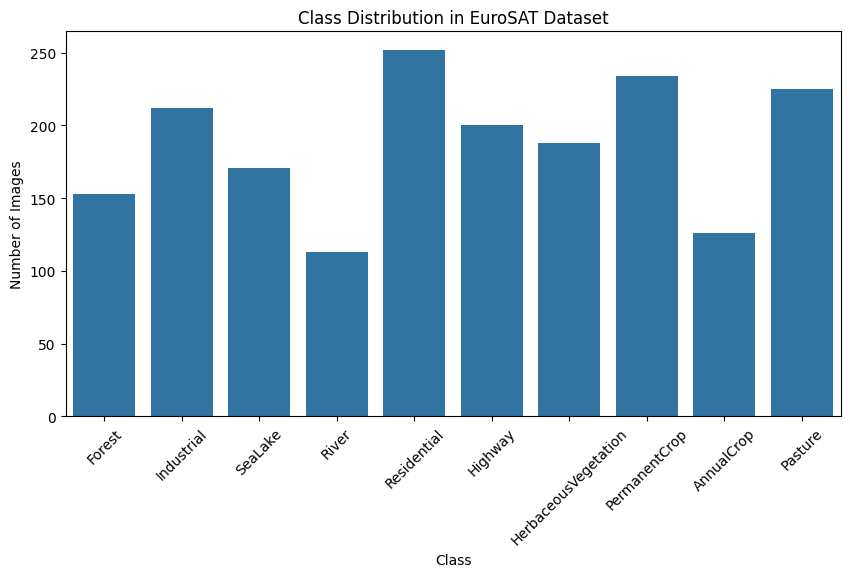

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Get class names and count images per class
classes = os.listdir(data_dir)
class_counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=classes, y=class_counts)
plt.title("Class Distribution in EuroSAT Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

b) **t-SNE for Dimensionality Reduction**

•	Feature Visualization: Use techniques like t-SNE or PCA to visualize high-dimensional spectral data in 2D, demonstrating class separability.
	•	Heatmaps & RGB Composites: Generate band-specific composites to showcase different land features (e.g., false-color imagery).

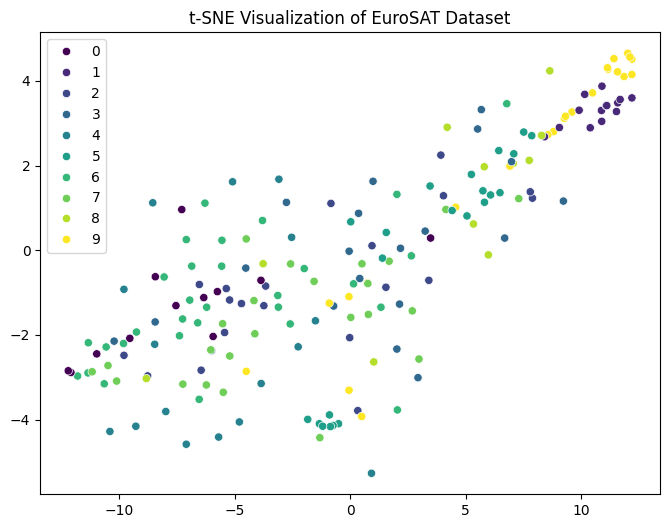

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Extract a subset of images and labels
X_subset, y_subset = [], []
for i, (images, labels) in enumerate(train_data):
    X_subset.append(images)
    y_subset.append(np.argmax(labels, axis=1))
    if i == 5: break  # Limit for visualization purposes

X_subset = np.vstack(X_subset)
y_subset = np.concatenate(y_subset)

# Reduce dimensionality with PCA first
X_pca = PCA(n_components=50).fit_transform(X_subset.reshape(X_subset.shape[0], -1))

# Apply t-SNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_pca)

# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_subset, palette="viridis", legend="full")
plt.title("t-SNE Visualization of EuroSAT Dataset")
plt.show()

3. **Model Building**

a. CNN Baseline Model

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enable mixed precision for faster GPU training
set_global_policy('mixed_float16')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Load and preprocess data, ensuring consistent input size
img_height, img_width = 150, 150 # consistent with target_size
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Eurosat2/2750/',  # Update with your dataset path
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical'
)
val_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Eurosat2/2750/',  # Update with your validation dataset path
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical'
)

# Use a pre-trained model for transfer learning
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet') # Updated input shape
base_model.trainable = False  # Freeze base model


# Add custom layers on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Optimize data loading, correcting output types
train_data = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32), # Changed image type to tf.float32
    output_shapes=((None, img_height, img_width, 3), (None, train_generator.num_classes)) # Explicitly define output shapes
).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_types=(tf.float32, tf.float32), # Changed image type to tf.float32
    output_shapes=((None, img_height, img_width, 3), (None, val_generator.num_classes))  # Explicitly define output shapes
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Train on a smaller subset of data
small_train_data = train_data.take(100)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculate steps per epoch
train_steps = train_generator.samples // train_generator.batch_size
val_steps = val_generator.samples // val_generator.batch_size


# Train the model with specified steps per epoch
history = model.fit(
    small_train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[early_stop]
)

Found 1874 images belonging to 10 classes.
Found 1874 images belonging to 10 classes.


<ipython-input-5-7d180f1e60f4>:36: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet') # Updated input shape


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 564s 19s/step - accuracy: 0.1336 - loss: 6.9470 - val_accuracy: 0.3658 - val_loss: 6.8532
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2840 - loss: 4.2026 - val_accuracy: 0.4177 - val_loss: 1.7491
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2633 - loss: 2.0481 - val_accuracy: 0.4403 - val_loss: 1.7385
Epoch 4/10
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3005 - loss: 1.9725

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 567ms/step - accuracy: 0.3115 - loss: 1.9714 - val_accuracy: 0.4586 - val_loss: 1.6968
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 64s 983ms/step - accuracy: 0.3023 - loss: 1.9662 - val_accuracy: 0.4110 - val_loss: 1.7194
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3470 - loss: 1.8454 - val_accuracy: 0.5155 - val_loss: 1.5586
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 929ms/step - accuracy: 0.3689 - loss: 1.8124 - val_accuracy: 0.4646 - val_loss: 1.5225
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 620ms/step - accuracy: 0.3859 - loss: 1.7285 - val_accuracy: 0.5298 - val_loss: 1.3944
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 927ms/step - accuracy: 0.3875 - loss: 1.7240 - val_accuracy: 0.5796 - val_loss: 1.3470
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 837ms/step - accuracy: 0.4307 - loss: 1.6140 - val_accuracy: 0.5320 - val_loss: 1.3606


**b. Using Pretrained Models (Transfer Learning)**

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load EfficientNet with ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculate steps per epoch if using generators
train_steps = train_generator.samples // train_generator.batch_size
val_steps = val_generator.samples // val_generator.batch_size

# Train the model with specified steps per epoch and early stopping
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[early_stop]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.3242 - loss: 4.7379 - val_accuracy: 0.6746 - val_loss: 1.6752
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7191 - loss: 1.2280 - val_accuracy: 0.8536 - val_loss: 0.4433
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8596 - loss: 0.4587 - val_accuracy: 0.8674 - val_loss: 0.3647
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 870ms/step - accuracy: 0.8650 - loss: 0.3871 - val_accuracy: 0.8873 - val_loss: 0.3266
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 912ms/step - accuracy: 0.8791 - loss: 0.3796 - val_accuracy: 0.9011 - val_loss: 0.2838
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 909ms/step - accuracy: 0.8716 - loss: 0.3493 - val_accuracy: 0.9155 - val_loss: 0.2459
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 914ms/step - accuracy: 0.9019 - loss: 0.3032 - val_accuracy: 0.9105 - val_loss: 0.2637
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 873ms/step - 

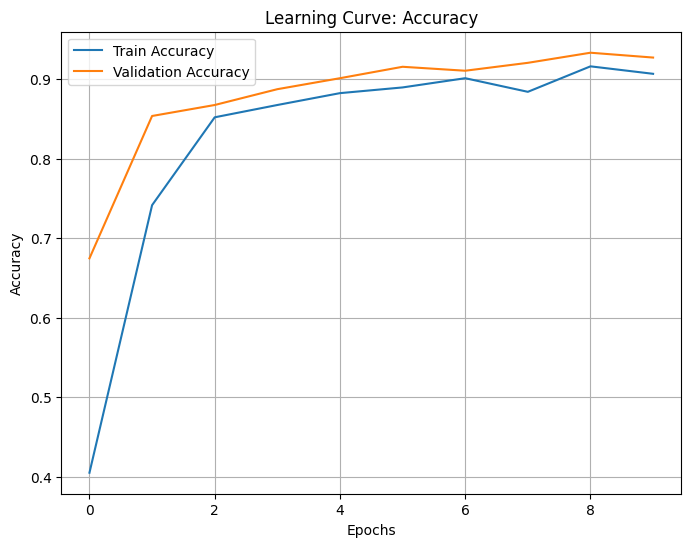

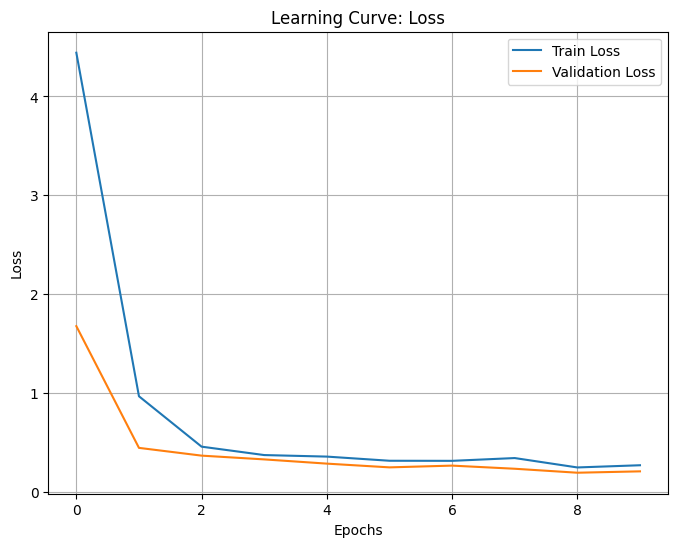

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**4. Evaluation and Explanability**

**a. Model Evaluation**

Custom Metrics: Beyond accuracy, use metrics like F1-score, confusion matrix, and AUC-ROC to show class-wise performance.

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━

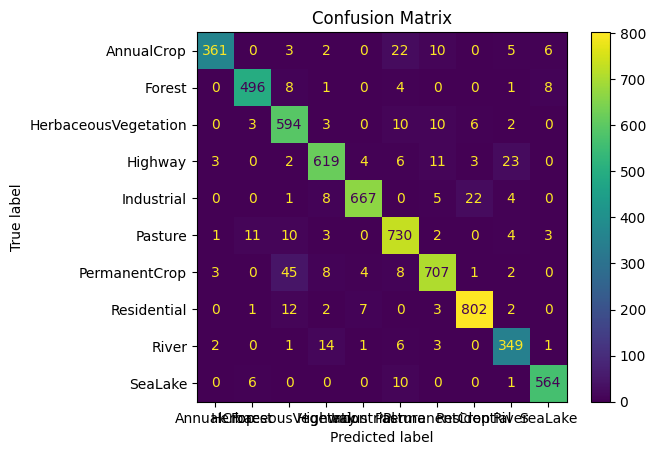

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Instead of resetting, recreate the val_data iterator:
val_data = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, img_height, img_width, 3), (None, val_generator.num_classes))
).prefetch(buffer_size=tf.data.AUTOTUNE)


# Optionally take a smaller subset for quicker evaluation
val_data_subset = val_data.take(100)  # Reduce to first 100 samples

# Collect predictions and true labels in lists before converting to numpy arrays
y_pred_list = []
y_true_list = []

# Iterate through the dataset, predict, and store results
for images, labels in val_data_subset:
    y_pred_list.extend(np.argmax(model.predict(images), axis=1))
    y_true_list.extend(np.argmax(labels, axis=1))

# Convert to NumPy arrays for confusion matrix calculation
y_pred = np.array(y_pred_list)
y_true = np.array(y_true_list)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys()) # Use val_generator's class_indices
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

**Interpretation of Results**

**Confusion Matrix Overview**

**Structure:** The confusion matrix is a square matrix where:

Rows represent true classes (actual labels).
Columns represent predicted classes.
Diagonal Elements: These indicate correct predictions (i.e., instances where the predicted class matches the true class).
Off-Diagonal Elements: These indicate misclassifications:

Values in row i and column j represent instances where true class i was predicted as class j.

**Insights from Confusion Matrix**

**Performance Assessment:**

A high number of correct predictions (high values on the diagonal) indicates good model performance.

Low values in off-diagonal cells suggest that misclassifications are minimal.

**Class Imbalance:**

If certain classes have significantly higher counts in their respective rows compared to others, this may indicate class imbalance in your dataset.

**Identifying Misclassifications:**

By examining specific off-diagonal entries, you can identify which classes are commonly confused with one another. For example, if many instances of class A are predicted as class B, this could suggest that these classes share similar features.

**Model Improvement Opportunities:**

If certain classes are consistently misclassified, it may be beneficial to gather more training data for those classes or apply techniques such as data augmentation to improve model performance.

**Conclusion**

The output of this code provides valuable insights into how well your model performs on a validation dataset. The confusion matrix visually represents prediction accuracy across different classes, allowing you to assess overall performance and identify areas for improvement.

**b. Grad-CAM for Explanability**


Explainable AI (XAI):
Implement Grad-CAM or SHAP to visualize model decision-making processes, enhancing transparency.

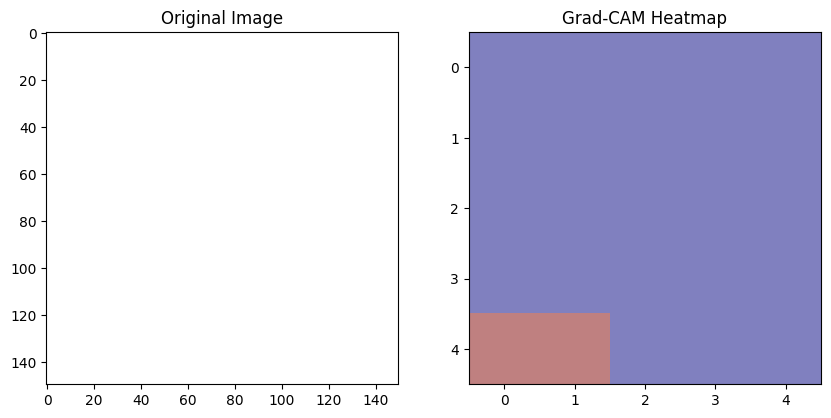

In [9]:
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions)]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Convert conv_outputs to a NumPy array to make it mutable
    conv_outputs = conv_outputs[0].numpy()

    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Apply Grad-CAM on a sample image
# Get a single batch from the train_data iterator
for images, labels in train_data.take(1):  # Take only one batch
    sample_image = images[0].numpy()  # Get the first image from the batch and convert to NumPy array
    break  # Exit the loop after getting one batch

sample_image_array = np.expand_dims(sample_image, axis=0)
heatmap = grad_cam(model, sample_image_array, 'block7a_project_conv') # changed layer_name to a valid layer in EfficientNetB0

# Display the original image and the heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_image)  # Display the original image first
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap
plt.title("Grad-CAM Heatmap")

plt.show()

**Interpretation of Outputs**

**Original Image**

What You See: This subplot displays the input image that was fed into the model for which you are generating a Grad-CAM heatmap.

**Grad-CAM Heatmap**

What You See: This subplot overlays a heatmap on top of the original image. The heatmap indicates which regions of the image were most influential in making the prediction.

**Color Interpretation:**

Warm Colors (Red/Yellow): Areas that contributed positively to predicting a certain class. These areas are where the model focused its attention when making its prediction.
Cool Colors (Blue): Areas that had little to no contribution to the prediction.

**Insights Gained**

By analyzing where the model is "looking" when making predictions, you can gain insights into its decision-making process. For example:
If certain critical features (like specific objects or textures) are highlighted in warm colors, it suggests that these features are important for classification.

If irrelevant areas are highlighted, it may indicate potential issues with model training or data representation.

**Conclusion**

The output of this code provides a visual understanding of how your EfficientNetB0 model interprets an input image. By using Grad-CAM, you can identify which parts of an image influenced its classification, allowing for better interpretability and debugging of your model's behavior.

In [23]:
!pip install gradio
import gradio as gr
import numpy as np
import random
import os  # Assuming your images are stored locally

# Function to retrieve an image based on user input
def get_image_response(user_input):
    # Define the image folder path
    image_folder = "/content/drive/MyDrive/Eurosat2/2750/"  # Update this path to your actual image directory
    images = os.listdir(image_folder)

    # Filter images based on user input (simple keyword matching)
    matched_images = [img for img in images if user_input.lower() in img.lower()]

    if matched_images:
        # Randomly select one of the matched images
        selected_image = random.choice(matched_images)
        return os.path.join(image_folder, selected_image)  # Return the path to the selected image
    else:
        return None  # No matching image found

# Define the Gradio interface
def chatbot_response(user_message, chat_history):
    chat_history.append({"role": "user", "content": user_message})

    # Get the corresponding image for the user's message
    image_path = get_image_response(user_message)  # Pass user_message instead of image_folder

    if image_path:
        response_message = "Here is the segmented image you requested:"
        chat_history.append({"role": "assistant", "content": response_message})
        return "", chat_history, image_path  # Return updated chat history and image path
    else:
        response_message = "Sorry, I couldn't find an image related to your query."
        chat_history.append({"role": "assistant", "content": response_message})
        return "", chat_history, None  # Return updated chat history and no image

# Set up Gradio Blocks interface
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(type="messages")
    msg = gr.Textbox(placeholder="Ask me about an image...")
    clear = gr.Button("Clear")

    # Create a variable to store the gr.Image component
    image_output = gr.Image(label="Segmented Image", type="filepath")

    # Use the image_output component in the outputs list
    msg.submit(chatbot_response, [msg, chatbot], [msg, chatbot, image_output])

    clear.click(lambda: None, None, chatbot)  # Clear button functionality

# Launch the app
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://597c1590cabde7c0c0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
